In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

from models import Autoencoder, DEC
from utils import *

In [4]:
input_dim = 784
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.01

device = get_device()

In [5]:
# data, labels = load_digits(return_X_y=True)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
#
# tensor_x = torch.Tensor(data).to(device)
#
# indices = torch.arange(len(tensor_x)).to(device)
# dataset = TensorDataset(tensor_x, indices)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
train_dataset, test_data = load_mnist()
train_loader, test_loader = create_dataloaders(train_dataset, test_data, batch_size=256)

tensor_x, labels = get_input_matrix(train_dataset, device=device)

# Autoencoder Training

In [7]:
ae = Autoencoder(input_dim, latent_dim).to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

In [8]:
img_indices = [34, 543, 2345]
ae_losses, images = train_autoencoder(
    ae,
    train_loader,
    ae_optimizer,
    mse_loss,
    epochs=10,
    image_indices=img_indices,
    device=device,
)

Epoch 1/10: average loss = 0.0598
Epoch 2/10: average loss = 0.0316
Epoch 3/10: average loss = 0.0242
Epoch 4/10: average loss = 0.0205
Epoch 5/10: average loss = 0.0181
Epoch 6/10: average loss = 0.0162
Epoch 7/10: average loss = 0.0149
Epoch 8/10: average loss = 0.0141
Epoch 9/10: average loss = 0.0134
Epoch 10/10: average loss = 0.0129


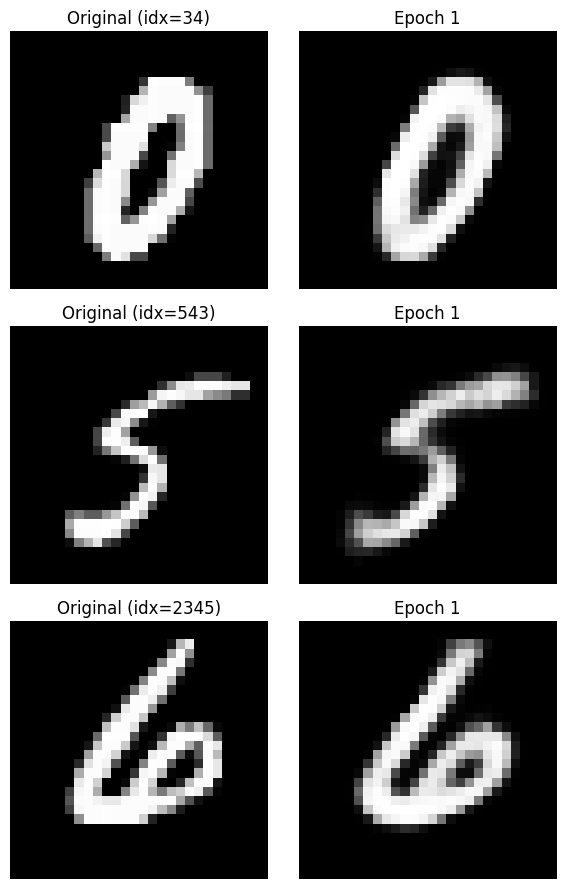

In [9]:
plot_all_reconstructions(images)

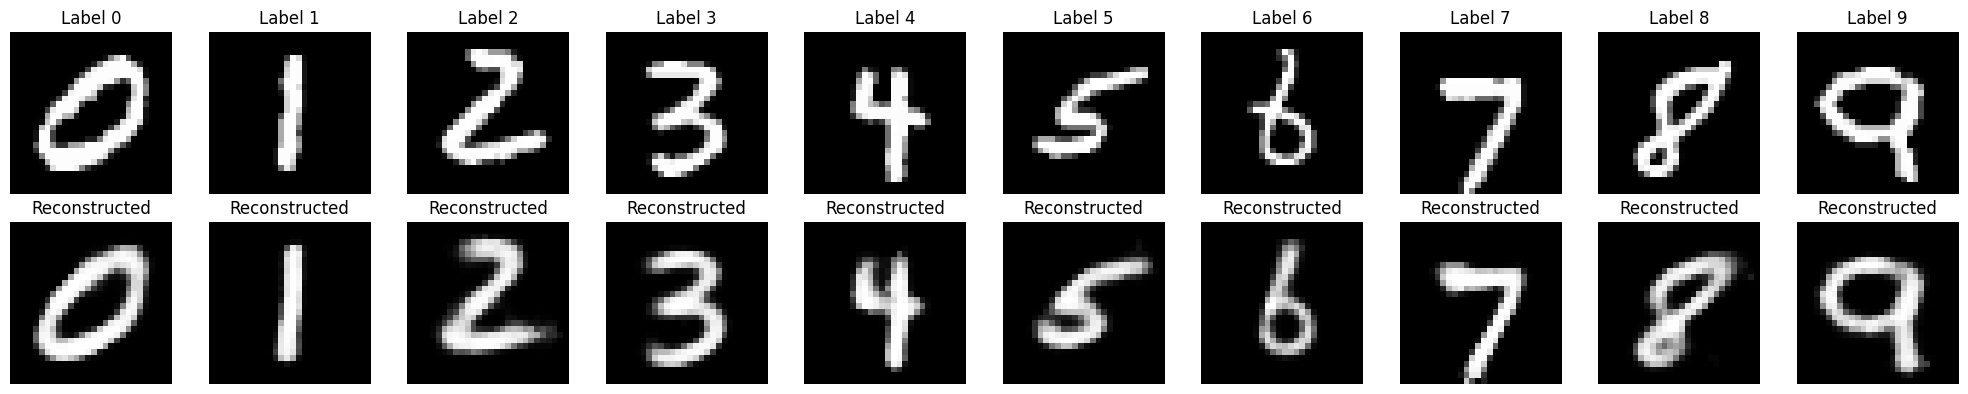

In [10]:
plot_classes_reconstruction(
    ae,
    train_dataset,
    device=device
)

# DEC Training

In [11]:
dec = DEC(ae, n_clusters, latent_dim).to(device)

dec_optimizer = optim.SGD(dec.parameters(), lr=learning_rate, momentum=0.9)
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')

### Uncomment the lines below for custom training


In [14]:
dec_losses = train_dec(
    dec,
    train_loader,
    dec_optimizer,
    kl_loss_fn,
    tensor_x,
    epochs=50,
    device=device,
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7168x28 and 784x500)

In [121]:
# torch.save(dec.state_dict(), "../checkpoints/dec_mnist.pth")

### Load pretrained Autoencoder

In [20]:
dec.load_state_dict(torch.load("../checkpoints/dec_mnist.pth"))
dec.eval()

DEC(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=10, bias=True)
  )
)

# Model evaluation

In [13]:
dec.eval()
with torch.no_grad():
    print(tensor_x.shape)
    q_final, full_z_np = dec(tensor_x)
    full_z_np = full_z_np.cpu().numpy()
    pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)

print(f"Adjusted Rand Score (ARI): {ari:.4f}")
print(f"Normalized mutual information: {nmi:.4f}")
print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

torch.Size([60000, 784])
Adjusted Rand Score (ARI): 0.7699
Normalized mutual information: 0.8240
Predicted Cluster Counts: [6106 5429 5803 5924 5702 4130 6562 8051 6275 6018]


# Plot results

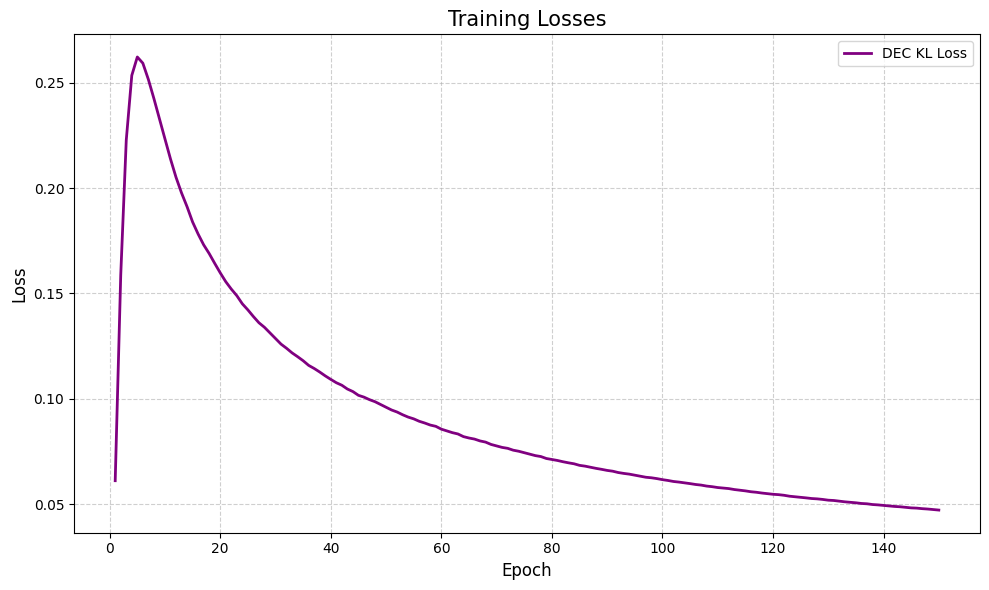

In [14]:
plot_losses(dec_losses=dec_losses)

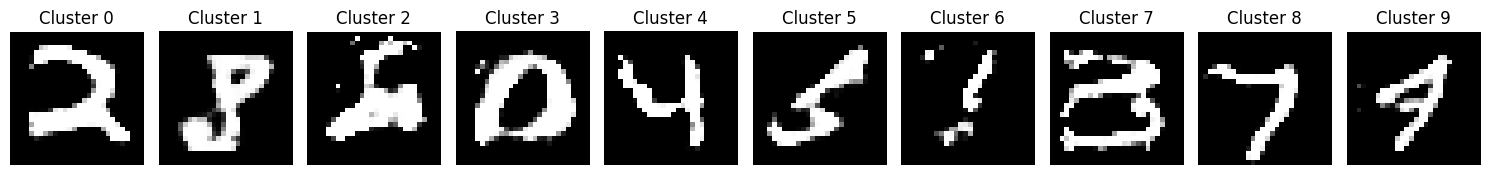

In [15]:
plot_dec_centers(dec, ae)

In [16]:
indices = []

while True:
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[idx]
    if label == 9:
        indices.append(idx)

    if len(indices) == 10:
        break

# plot_ae_reconstructions(ae, train_dataset, indices=indices)

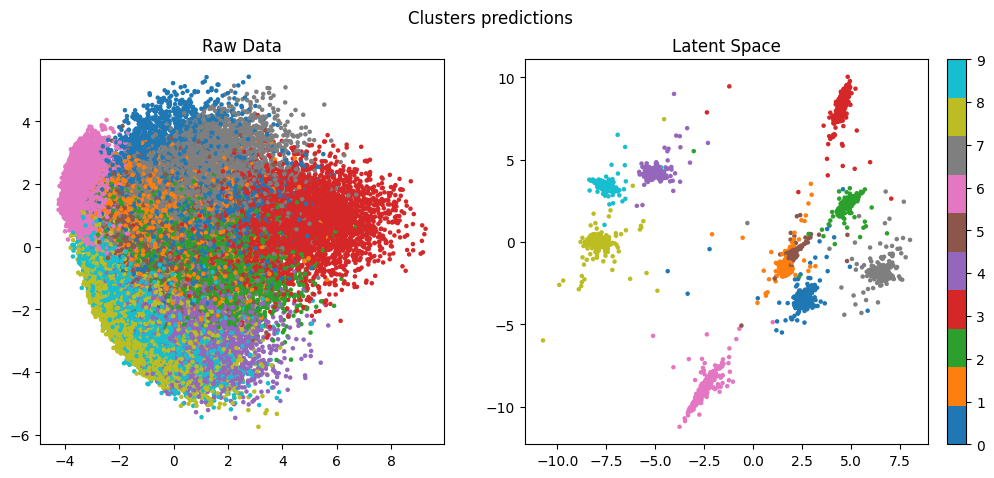

In [17]:
plot_pca(data, full_z_np, pred_labels, title='Clusters predictions')

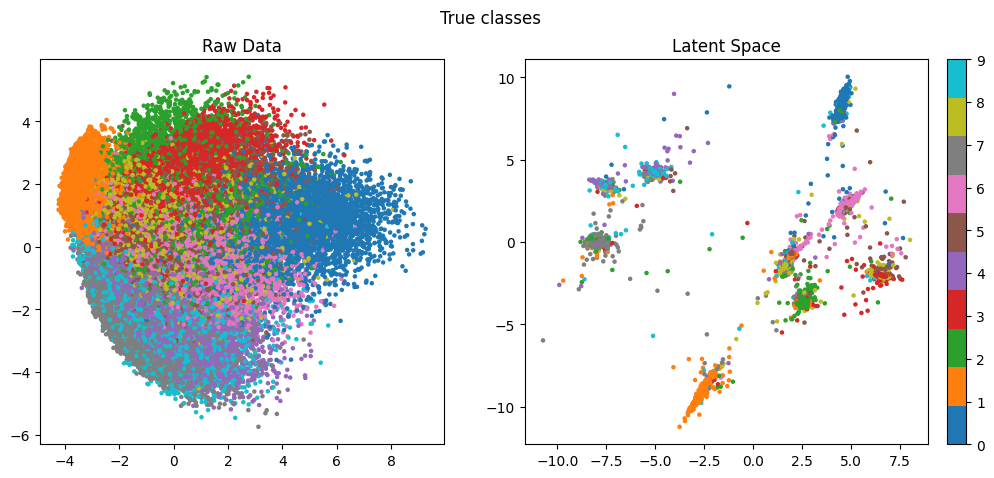

In [18]:
plot_pca(data, full_z_np, labels, title='True classes')

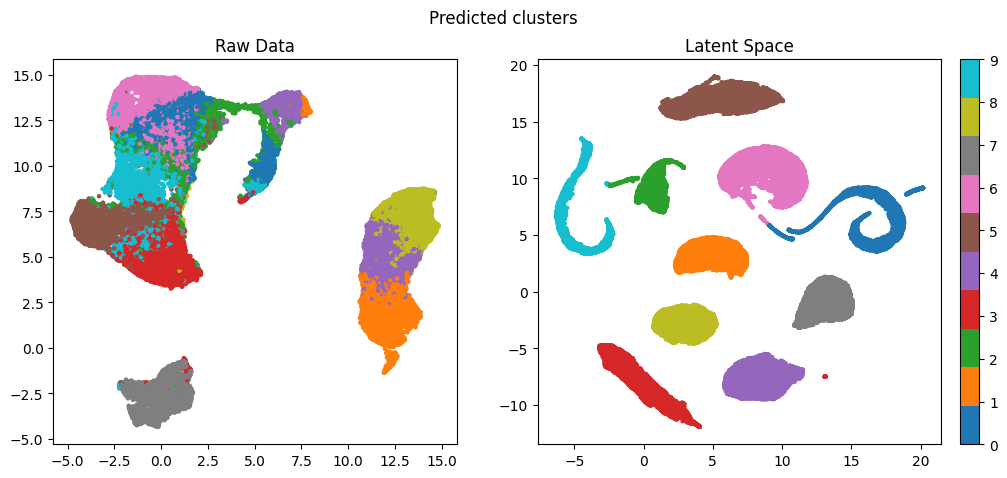

In [119]:
plot_umap(data, full_z_np, pred_labels, title='Predicted clusters')

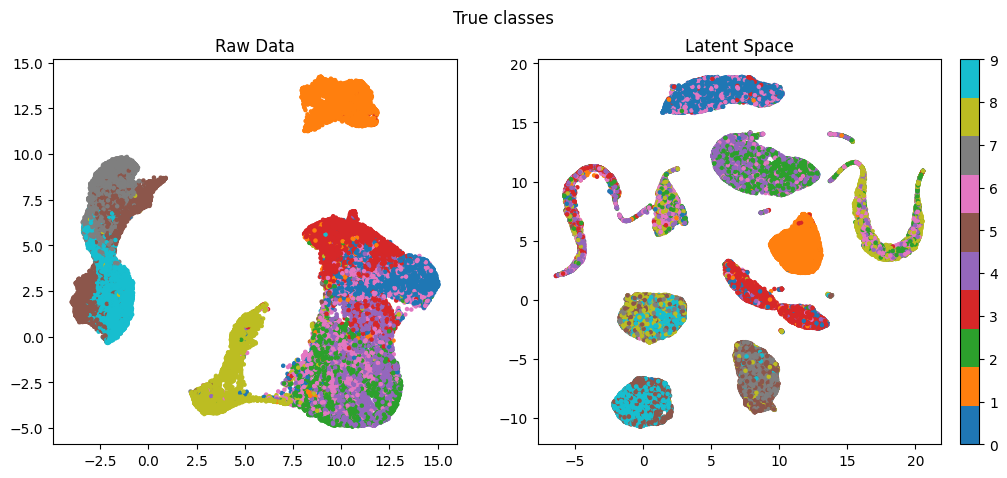

In [120]:
plot_umap(data, full_z_np, labels, title='True classes')